# Summary

...

# Imports/Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import data
import dataset
import model
import evaluation
import training
import distributed

## Configuration

...

In [2]:
class Config:
    # dataset
    path = '/data/users/jupyter-dam724/datadump(colliding)'
    solver = 'ros2'
    fixed_seq_len = 216
    batch_size = 64 
    ahead = 1
    tail = 1
    
    # device
    device_pref = 'cuda'
    device_ind = 1
    
    # model
    epoches = 10
    patience = 3
    lr = 1e-5
    save_path = '/data/users/jupyter-dam724/Scripts/Modelling/koopman-vit/init_koopman_vit_1.pth'
    
    from_checkpoint = None

# Dataset

...

In [3]:
data_params = {
    'path': Config.path, 
    'device_pref': Config.device_pref, 
    'solver': Config.solver, 
    'fixed_seq_len': Config.fixed_seq_len, 
    'ahead': Config.ahead, 
    'tail': Config.tail,
    'device_ind': Config.device_ind
}

device, (x_train_data, y_train_data), (x_valid_data, y_valid_data) = data.main(**data_params)

Number of file paths cached: 203040
Key: x_{i}_{n}, Value: /data/users/jupyter-dam724/datadump(colliding)/ros2_x_{i}_{m}.npy

Inst | Seq. Len. 
   1 | 215
   2 | 215
   3 | 215
   4 | 215
   5 | 215
   6 | 215
   7 | 215
   8 | 215
   9 | 215
  10 | 192 <-- 202
  11 | 215
  12 | 215
  13 | 215
  14 | 215
  15 | 215
  16 | 215
  17 | 215
  18 | 215
  19 | 215
  20 | 161 <-- 171
  21 | 215
  22 | 215
  23 | 215
  24 | 215
  25 | 215
  26 | 215
  27 | 215
  28 | 215
  29 | 156 <-- 166
  30 | 215
  31 | 215
  32 | 215
  33 | 215
  34 | 215
  35 | 215
  36 | 215
  37 | 215
  38 | 215
  39 | 215
  40 | 182 <-- 192
  41 | 215
  42 | 215
  43 | 215
  44 | 215
  45 | 215
  46 | 189 <-- 199
  47 | 215
  48 | 215
  49 | 174 <-- 184
  50 | 215
  51 | 215
  52 | 215
  53 | 199 <-- 209
  54 | 177 <-- 187
  55 | 215
  56 | 215
  57 | 215
  58 | 215
  59 | 215
  60 | 215
  61 | 215
  62 | 215
  63 | 215
  64 | 215
  65 | 174 <-- 184
  66 | 215
  67 | 215
  68 | 201 <-- 211
  69 | 215
  70 | 215
  71 |

In [4]:
dataset_params = {
    'x_train_data': x_train_data, 
    'y_train_data': y_train_data, 
    'x_valid_data': x_valid_data, 
    'y_valid_data': y_valid_data, 
    'device': device, 
    'batch_size': Config.batch_size
}

train_dl, valid_dl = dataset.main(**dataset_params)

# Model

...

In [5]:
from transformers import ViTModel

2024-11-20 21:42:16.433299: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 21:42:16.451086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 21:42:16.472473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 21:42:16.479100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 21:42:16.495400: I tensorflow/core/platform/cpu_feature_guar

In [6]:
vit = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model.freeze(vit)
model.unfreeze(vit.pooler) # Unfreeze to finetune on koopman cordinate estimation
model.unfreeze(vit.encoder.layer[-1])
model.unfreeze(vit.encoder.layer[-2])

In [8]:
koopmanVit = model.KoopmanViT(vit).to(device)

## Training

...

In [9]:
if Config.from_checkpoint is not None:
    load_params = {
        'model': koopmanVit, 
        'state_dict_path': Config.from_checkpoint
    }
    
    model.load_model_weights(**load_params)

In [ ]:
train_log, valid_log = [], []

def step(batch, model, criterion, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    loss = criterion(*model(x, y))
        
    return loss

training_params = {
    'train': train_dl, 
    'valid': valid_dl, 
    'model': koopmanVit, 
    'epochs': Config.epoches, 
    'patience': Config.patience, 
    'criterion': model.KoopmanViTLoss(1.0, 1.0, 1e-1, 1e-1), 
    'lr': Config.lr, 
    'save_path': Config.save_path, 
    'step': step, 
    'train_log': train_log, 
    'valid_log': valid_log, 
    'device': device,
    'loading_bar': False
}

training.train(**training_params)

Epoch 1/10, Train Loss: 67.84418230181699, Validation Loss: 56.18515800142656


## Evaluation

...

In [12]:
x, y = next(iter(valid_dl))

In [13]:
koopmanVit.eval()
with torch.no_grad():
    out = koopmanVit(x.to(device), y.to(device))

tensor(49.0638, device='cuda:1')
tensor(4.3346, device='cuda:1')


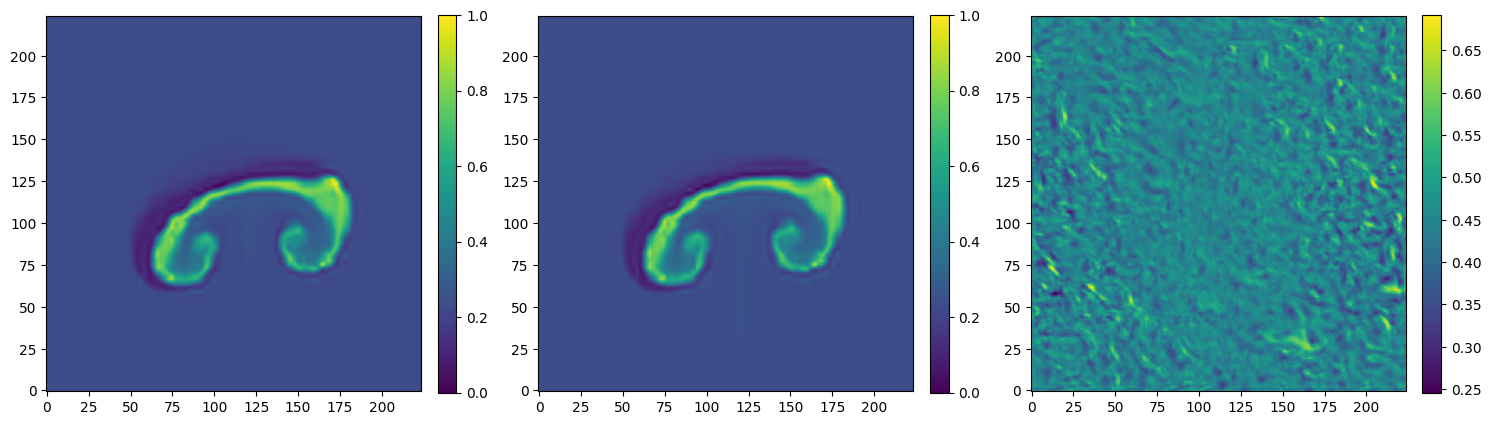

In [15]:
ind = 8
channel = 2

fig, ax = plt.subplots(1, 3, figsize=(18, 8))

a1 = ax[0].imshow(out[0][ind][channel].cpu(), origin='lower')
a2 = ax[1].imshow(out[1][ind][channel].cpu(), origin='lower')
a3 = ax[2].imshow(out[2][ind][channel].cpu(), origin='lower')

fig.colorbar(a1, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a2, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a3, ax=ax[2], orientation='vertical', fraction=0.046, pad=0.04)

print(torch.linalg.norm(out[1][ind][channel] - out[2][ind][channel]))
#print(torch.linalg.norm(out[2][ind][channel] - out[2][ind][channel+1]))
print(torch.linalg.norm(out[2][ind][channel] - out[2][ind+1][channel]))

## Distributed Training

Using huggingface accelerate: https://huggingface.co/blog/pytorch-ddp-accelerate-transformers